In [95]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
%matplotlib inline

Initialize parameters:
- number of agents $n$
- skill level of agents $a$
- simplicity of project $r$
- $\alpha = a \cdot r$ denotes the aptitude of the agents when working on a project
- $R$ denotes the reward vector for the different projects
- $w(i,j)$ denotes the weight of agent $i$ choosing project $j$
- $p(i,j)$ denotes the normalized weights to a probability distribution
- $\epsilon$ parameter for the weight updates
- $x$ is the decision variable to optimize incentive

In [278]:
# Number of agents
n = 2
a = np.ones((n,1))
# a = np.abs(np.random.normal(0, 1, size = (n,1)))
r = np.ones((n,1))
alpha = a.dot(r.T)
R = np.zeros((n,1))
W = np.ones((n,n))
p = W / np.sum(W, axis = 1).reshape(n,1)
epsilon = 1/2 #(larger the epsilon the more it encourages exploration)
x = 1/n * np.ones((n,n))
x = np.array([[1/4,3/4],[3/4,1/4]])

In [206]:
# Ignore this!!!
# class Agent():
#     def __init__(self, epsilon):
#         self.e = epsilon
#         self.w = 

In [267]:
def initializepara(n):
    a = np.ones((n,1))
    r = np.ones((n,1))
    alpha = a.dot(r.T)
    R = np.zeros((n,1))
    W = np.ones((n,n))
    p = W / np.sum(W, axis = 1).reshape(n,1)
    return a, r, alpha, R, W, p

def cal_reward(alpha, p):
    """
    Calculates reward at time t. Returns a (n, 1) numpy array with the expected rewards generated by each project. 
    Plus one at the end to prevent zero reward.
    This output can be thought of as the expected reward obtained if the agents choose the projects based
    on their probability distributions.
    Inputs:
    - alpha:  (n, n) numpy array of aptitudes; alpha(i,j) denoting the aptitude of agent i on project j.
    - p: (n, n) numpy array where each row denotes distribution of each agent working on the projects.
    """
    return np.log(np.sum(alpha * p, axis = 1) + 1)

def cal_utility(x, R):
    """
    Computes the utiliy for each agent at each time step. Returns a (n, n) numpy array with the i,j being
    the utility of agent i from project j.
    Inputs:
    - x: (n, n) numpy array representing the decision variable to optimize incentives. The columns sum to 1. 
    - R: (n, 1) numpy array with the expected rewards generated by each project.
    """
    R = R.reshape(n,1)
    return x * R 

def weightupdates(epsilon, W, u):
    """
    Takes in the weight W at time t and performs one timestep. Returns the weights at time t+1.
    Input:
    - epsilon: a real valued number in [0, 0.5] that does the weight updates.
    - W: a (n, n) array of weights with i,j being the weight for project j for agent i. 
    - u: a (n, n) array that the weight updates are based on.
    """
    return W * np.power((1 + epsilon), u)

def normalizew(W):
    """
    Takes in the weights and normalizes them.
    Input:
    - W: (n, n) numpy array of weights.
    """
    return W / np.sum(W, axis = 1).reshape(n,1)

def one_step(W, R, x, alpha, epsilon):
    """
    Takes in weights, reward, x, alpha and epsilon at time t and produces the new weights for time t+1.
    We shall take alpha and epsilon to be constant for the time being.
    """
    p = normalizew(W) # normalize weights at time t
    R = cal_reward(alpha, p) # expected reward for distribution p
    u = cal_utility(x, R) # utitliy obtained to update the weights
    W = weightupdates(epsilon, W, u) # new weights obtained after using u to update weights
    p = normalizew(W) # new distribution for the strategy
    return p, W, R, u

In [208]:
def unroll(W):
    """
    Unrolls a (n, n) array into a (n * n, 1) array
    """
    n = W.shape[0]
    return W.reshape(n * n, 1)

def ununroll(W):
    """
    Ununroll a (n * n, 1) array into a (n, n) array
    """
    m = W.shape[0]
    n = int(np.sqrt(m))
    return W.reshape(n, n)

In [209]:
def msteps(W, R, x, alpha, epsilon, m):
    """
    Iterate over m number of steps.
    """
    n = W.shape[0]
    U = np.zeros((n,n))
    W_history = np.zeros((m, n * n))
    p_history = np.zeros((m, n * n))
    for i in range(m):
        p, W, R, u = one_step(W, R, x, alpha, epsilon)
        W_history[i, :] = unroll(W).T
        p_history[i, :] = unroll(p).T
        U += u
#         print ('Utility for time %d:\n' %i, u)
#         print ('Cumulative utility: \n', U)
#         print ('Probabilites at time %d\n' %i, p)
    #print ('Time-average probabilities: \n', p)  
    return W_history, p_history, p

In [351]:
def runandplot(W, R, x, alpha, epsilon, m):
    W_history, p_history, p = msteps(W, R, x, alpha, epsilon, 1000)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    plt.subplots_adjust(hspace = 0.5)
    ax[0].plot(W_history[:,0],'b',W_history[:,1],'r--',W_history[:,2],'g',W_history[:,3],'y--')
    ax[1].plot(p_history[:,0],'b',p_history[:,1],'r--',p_history[:,2],'g',p_history[:,3],'y--')
    ax[0].set_title('Changes in weights over %d time steps' %m)
    ax[1].set_title('Changes in probability over %d time steps' %m)
    ax[0].set_xlabel('Time step, t')
    ax[0].set_ylabel('Weight')
    ax[1].set_xlabel('Time step, t')
    ax[1].set_ylabel('Probability')
    ax[0].legend(['W(1,1)','W(1,2)','W(2,1)','W(2,2)'])
    ax[1].legend(['p(1,1)','p(1,2)','p(2,1)','p(2,2)'])
    print ('alpha: \n', alpha)
    print ('epsilon:', epsilon)
    print ('x: ',x)
    print ('Number of iterations: ',m)
    plt.savefig('plot.png')

In [352]:
x = np.array([[1/4,7/8],[3/4,1/8]])
print (x)

[[ 0.25   0.875]
 [ 0.75   0.125]]


alpha: 
 [[2 2]
 [1 1]]
epsilon: [ 0.5  0.5]
x:  [[ 0.25   0.875]
 [ 0.75   0.125]]
Number of iterations:  1000


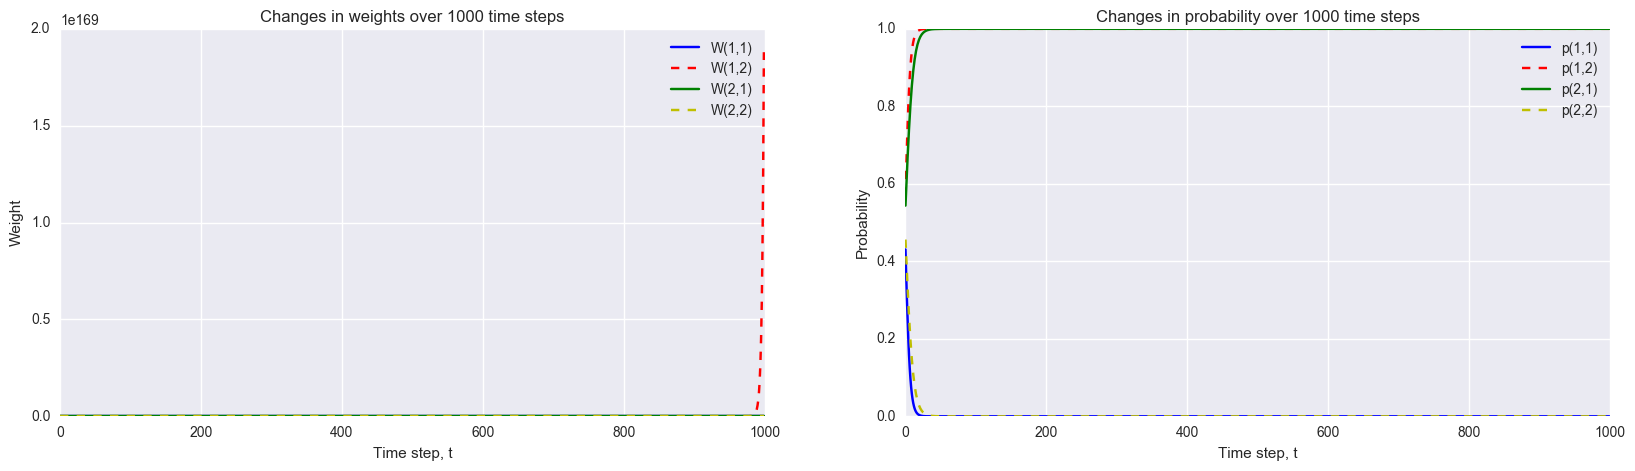

In [353]:
epsilon = np.array([1/2,1/2])
runandplot(W, R, x, alpha, epsilon, 1000)

From the above result, we see that for small $\epsilon$ say 0.001, the agent come to a faster conclusion as compared to an agent with a bigger $\epsilon$ which we set to be 0.5. 

For these parameters, we get the following result:

In [348]:
def varying(a, r, epsilon, x):
    a = a.reshape(n,1)
    r = r.reshape(1,n)
    alpha = a.dot(r)
    R = np.zeros((n,1))
    W = np.ones((n,n))
    runandplot(W, R, x, alpha, epsilon, 1000)


alpha: 
 [[2 2]
 [1 1]]
epsilon: [ 0.5  0.5]
x:  [[ 0.66666667  0.66666667]
 [ 0.33333333  0.33333333]]
1000


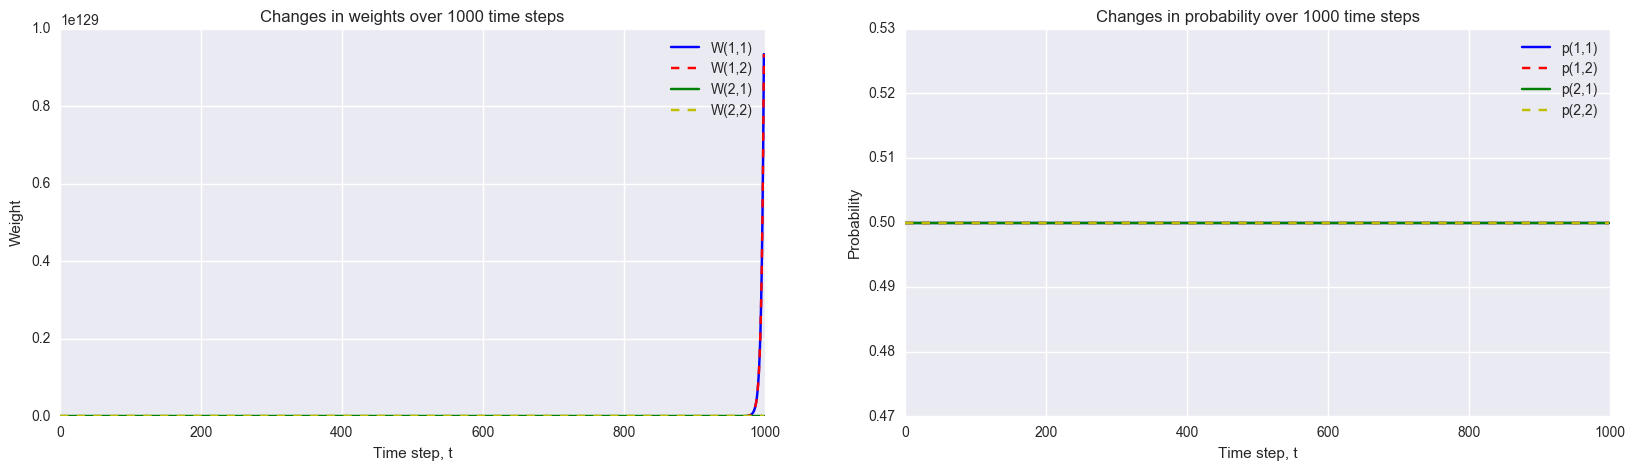

In [349]:
a = np.array([2,1])
r = np.array([1,1])
epsilon = np.array([0.5,0.5])
x = np.array([[2/3,2/3],[1/3,1/3]])
# vary the stuff above to get the results below
varying(a, r, epsilon, x)

In [269]:
a, r, alpha, R, W, p = initializepara(3)